<a href="https://colab.research.google.com/github/randyng524/fyp-pj/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!python --version

1.10.0+cu111
11.1
Python 3.7.13


In [ ]:
# Install rdkit
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO
 
 
logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)
 
 
def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """
 
    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )
 
    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)
 
    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return
 
        logger.info("force re-install")
 
    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)
 
    logger.info("python version: {}".format(python_version))
 
    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)
 
    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')
 
    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')
 
    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python==3.7.3",
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")
 
    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))
 
 
if __name__ == "__main__":
    install()

rdkit is already installed
rdkit is already installed


In [ ]:
import torch
pytorch_version = "torch-" + torch.__version__ + ".html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html


In [ ]:
import rdkit
from torch_geometric.datasets import MoleculeNet

In [ ]:
# Loading Load Delaney dataset
data = MoleculeNet(root=".", name="ESOL")
data

Processing...
Done!


ESOL(1128)

In [ ]:
print("Dataset length: ", data.len)
print("Dataset sample: ", data[10])
print("Sample  nodes: ", data[10].num_nodes)
print("Sample  edges: ", data[10].num_edges)

# edge_index = graph connections
# smiles = molecule with its atoms
# x = node features
# y = labels (dimension)

Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[6, 9], edge_index=[2, 12], edge_attr=[12, 3], y=[1, 1], smiles='O=C1CCCN1')
Sample  nodes:  6
Sample  edges:  12


In [ ]:
#convert smiles to rdkit molecule
data[10]["smiles"]

'O=C1CCCN1'

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

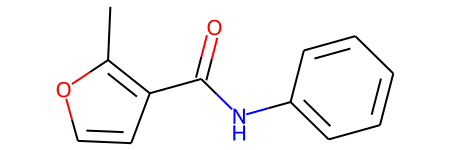

In [ ]:
molecule = Chem.MolFromSmiles(data[1]["smiles"])
molecule

In [ ]:
type(molecule)

rdkit.Chem.rdchem.Mol

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv
from torch_geometric.nn import TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64 # Dimension of the embedding vector.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent inherit by CCN class
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.Conv1 = GCNConv(embedding_size, embedding_size)
        self.Conv2 = GCNConv(embedding_size, embedding_size)
        self.Conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, data.num_classes)

    def forward(self, x, edge_index, batch_index):
        # First Convolution layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # hidden Convolution layers
        hidden = self.Conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.Conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.Conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling
        hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim=1)

        
        out = self.out(hidden)

        return out, hidden

In [ ]:
model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (Conv1): GCNConv(64, 64)
  (Conv2): GCNConv(64, 64)
  (Conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=734, bias=True)
)
Number of parameters:  107806


In [ ]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")
# use Root mean squared error 
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
# Using GPU for training process
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 128
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    for batch in loader:
      batch.to(device)  
      optimizer.zero_grad() 
      # Pass back the node feature and connectivity information 
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      loss = torch.sqrt(loss_fn(pred, batch.y))       
      loss.backward()  
      # Gradients Updated and optimizer define step size
      optimizer.step()   
    return loss, embedding


losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Epoch 0 | Train Loss 4.577612400054932
Epoch 100 | Train Loss 0.5476264357566833
Epoch 200 | Train Loss 1.0440168380737305
Epoch 300 | Train Loss 0.6652711629867554
Epoch 400 | Train Loss 0.557057797908783
Epoch 500 | Train Loss 0.9413118958473206
Epoch 600 | Train Loss 0.604265034198761
Epoch 700 | Train Loss 0.5146664977073669
Epoch 800 | Train Loss 0.54318767786026
Epoch 900 | Train Loss 0.5380496978759766
Epoch 1000 | Train Loss 0.4773741662502289
Epoch 1100 | Train Loss 0.4117223024368286
Epoch 1200 | Train Loss 0.8231242895126343
Epoch 1300 | Train Loss 0.49661991000175476
Epoch 1400 | Train Loss 0.42364421486854553
Epoch 1500 | Train Loss 0.19940680265426636
Epoch 1600 | Train Loss 0.3934570550918579
Epoch 1700 | Train Loss 0.23356494307518005
Epoch 1800 | Train Loss 0.6390538811683655
Epoch 1900 | Train Loss 0.5264667272567749


In [ ]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()  #y is label data 
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-0.590,-0.388303
1,-0.800,-0.205137
2,-3.400,-3.363930
3,-1.960,-1.427803
4,-3.401,-1.968387
...,...,...
123,-1.790,-1.878878
124,-8.172,-7.836982
125,-1.400,-0.743700
126,-0.280,-0.720646


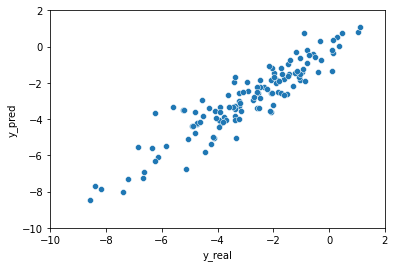

In [ ]:
import seaborn as sns
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-10, 2))
plt.set(ylim=(-10, 2))
plt